In [57]:
import pandas as pd
import boto3
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot_components_plotly, plot_components

In [58]:
import boto3
from botocore.exceptions import ClientError
import pandas as pd
from io import StringIO

bucket = 'sleep-quality-forecast-bucket'
key = 'processed/sleep_data_clean.csv'
s3 = boto3.client('s3')

# Load csv
obj = s3.get_object(Bucket=bucket, Key=key)
df = pd.read_csv(obj['Body'])
df.head()

,SESSION_DATE,SLEEP_SCORE,USAGE_HOURS,AHI,MASK_SESSION_COUNT,LEAK_50_PERCENTILE,LEAK_70_PERCENTILE,LEAK_95_PERCENTILE,DAY_OF_WEEK
0,2023-05-11,96,9.95,0.1,5,0.0,0.0,0.0,Thursday
1,2023-05-12,96,10.73,0.5,5,0.0,0.0,0.0,Friday
2,2023-05-13,98,10.22,0.3,4,0.0,0.0,0.0,Saturday
3,2023-05-14,100,9.97,0.3,2,0.0,0.0,0.0,Sunday
4,2023-05-15,95,8.80,0.6,6,0.0,0.0,0.0,Monday


In [59]:
target_columns = ['SLEEP_SCORE', 'AHI', 'MASK_SESSION_COUNT', 'USAGE_HOURS', 'LEAK_95_PERCENTILE']

18:43:02 - cmdstanpy - INFO - Chain [1] start processing
18:43:02 - cmdstanpy - INFO - Chain [1] done processing


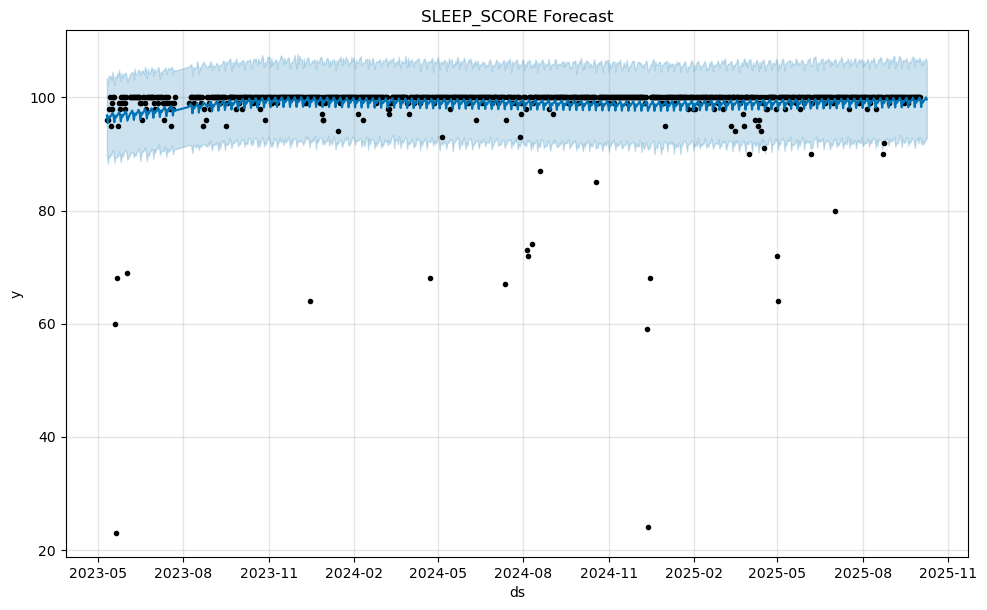

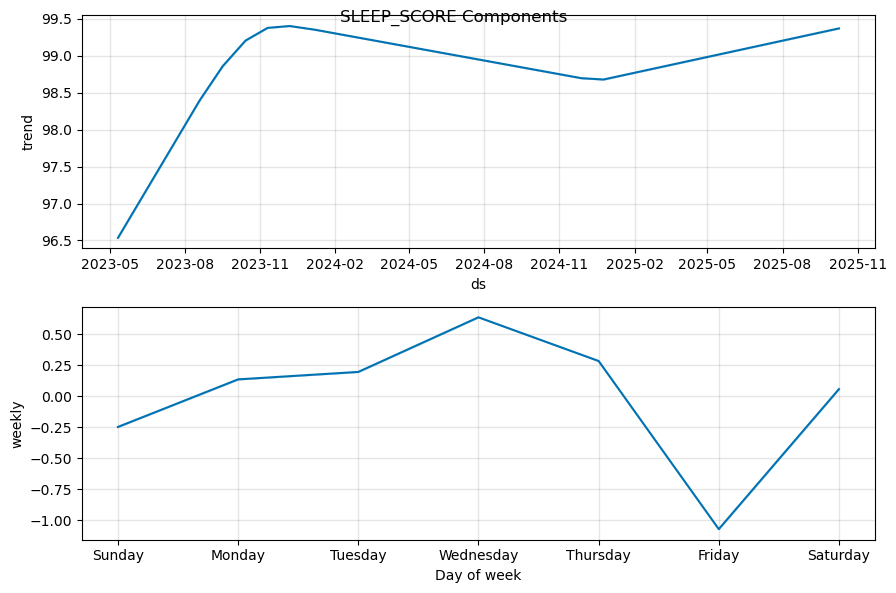

18:43:03 - cmdstanpy - INFO - Chain [1] start processing
18:43:03 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.8398832580146308


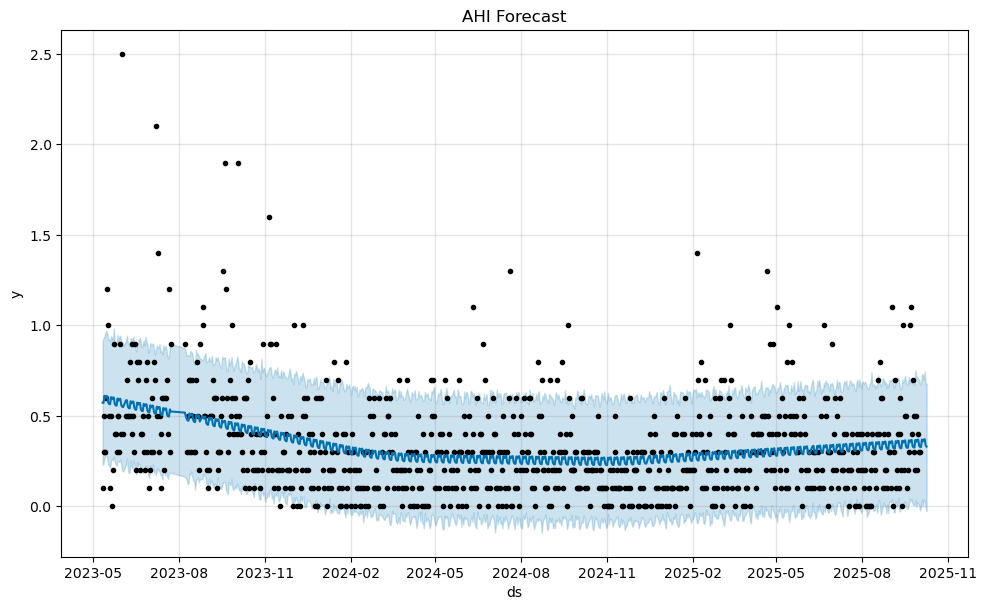

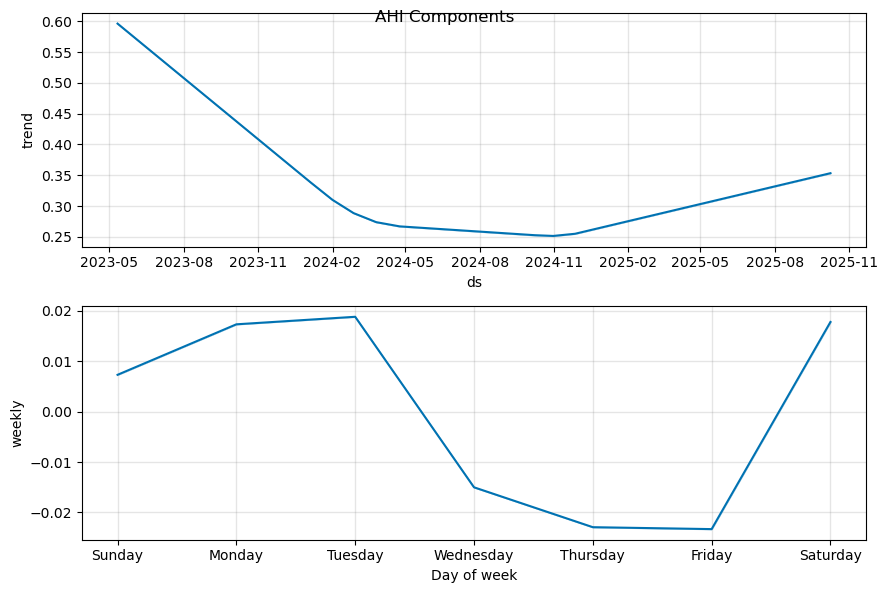

18:43:04 - cmdstanpy - INFO - Chain [1] start processing
18:43:04 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.23200415703094243


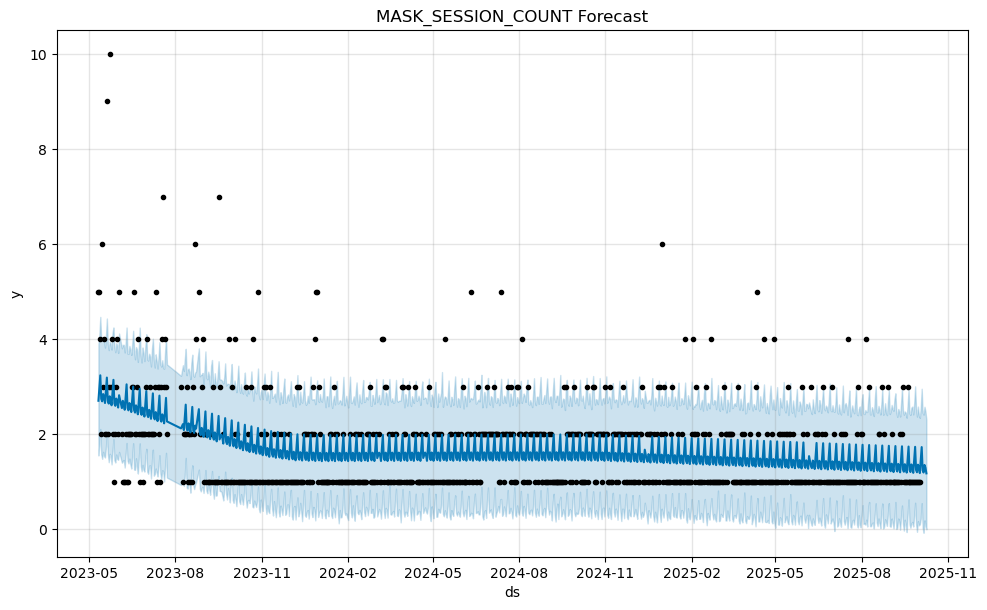

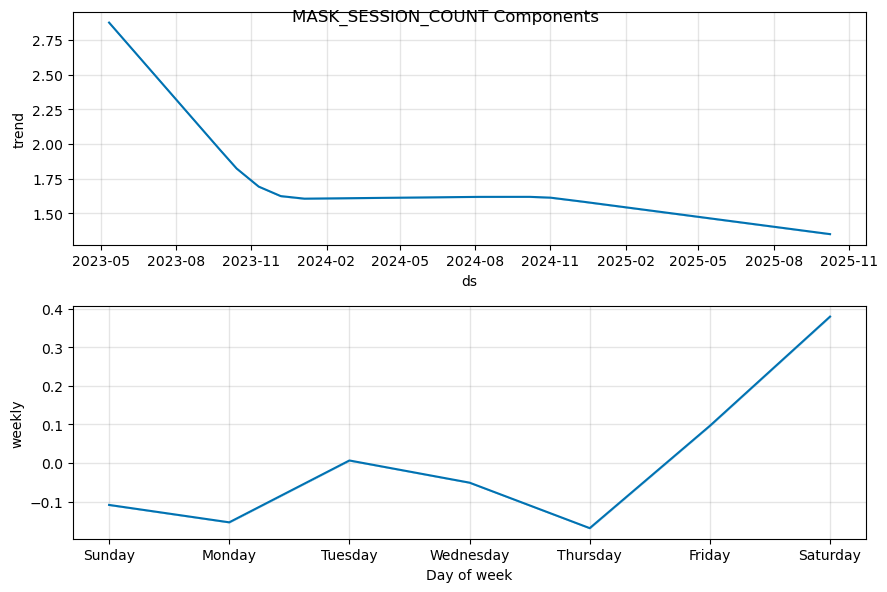

18:43:05 - cmdstanpy - INFO - Chain [1] start processing
18:43:05 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.7465642161966625


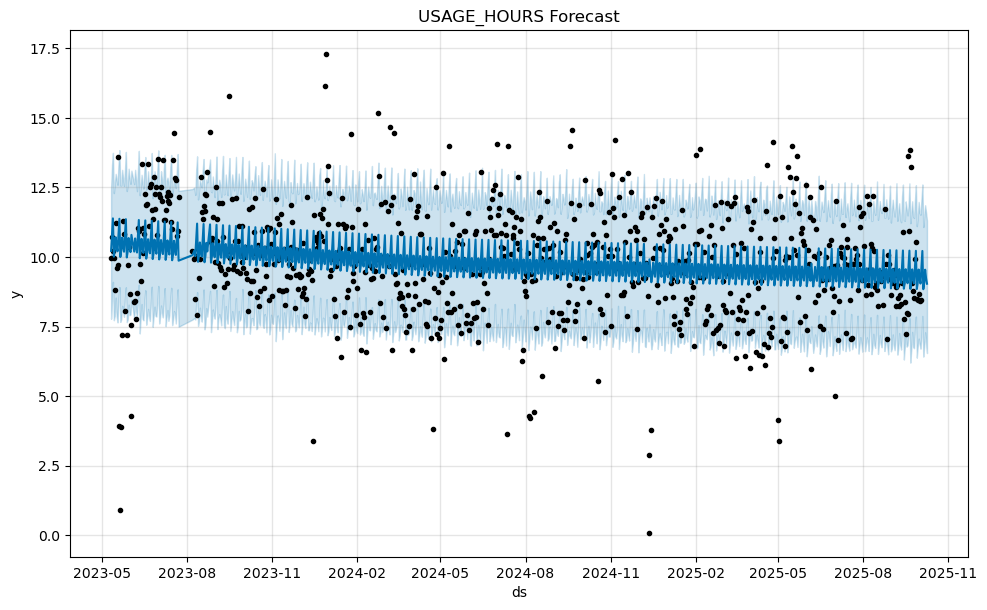

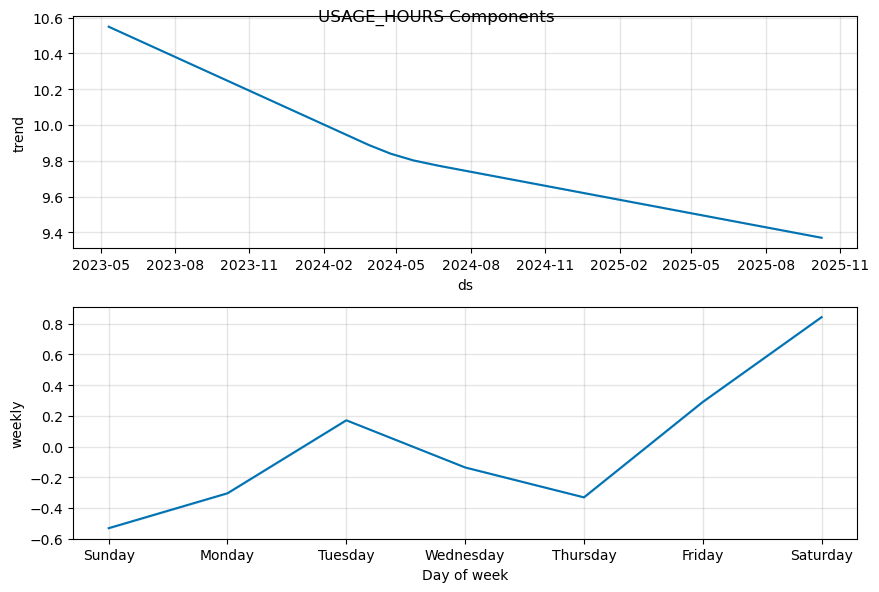

18:43:06 - cmdstanpy - INFO - Chain [1] start processing
18:43:06 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.5279481342801655


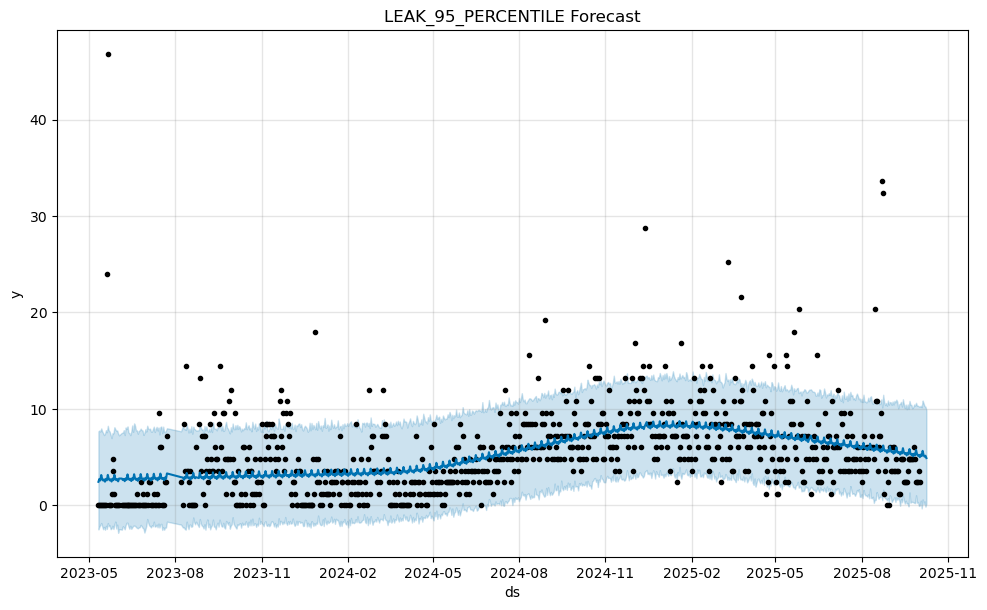

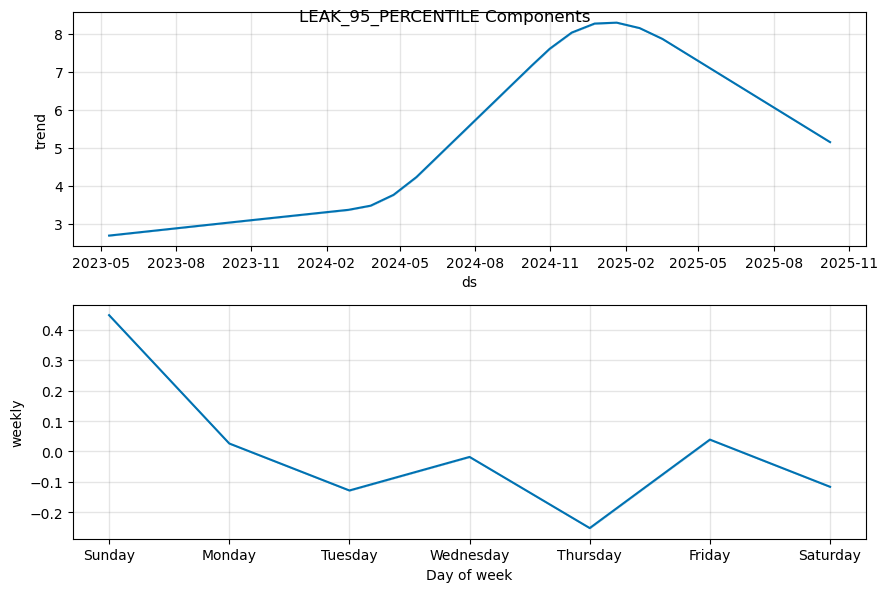

RMSE: 1.9581968481887493


In [61]:
results = {}
trained_models = {}

for col in target_columns:
    # prep data
    ts = df[['SESSION_DATE', col]].rename(columns={'SESSION_DATE': 'ds', col: 'y'})
    ts = ts.dropna()
    
    train = ts.iloc[:-7].copy()
    test = ts.iloc[-7:].copy()
    
    
    # train
    model = Prophet(weekly_seasonality=True, daily_seasonality=False, yearly_seasonality=False)
    model.fit(train)
    trained_models[col] = model
    
    # forecast last 7 days
    future = model.make_future_dataframe(periods=7)
    forecast = model.predict(future)
    
    # save results in 'results'
    results[col] = forecast
    
    # show plot
    fig = model.plot(forecast)
    plt.title(f"{col} Forecast")
    fig2 = model.plot_components(forecast)
    plt.suptitle(f"{col} Components")
    plt.show()

    # normalize time stamps
    forecast['ds'] = pd.to_datetime(forecast['ds']).dt.normalize()
    test['ds'] = pd.to_datetime(test['ds']).dt.normalize()

    # calc RMSE
    pred = forecast[['ds', 'yhat']].set_index('ds').join(test.set_index('ds'))
    pred['error'] = pred['yhat'] - pred['y']
    rmse = (pred['error']**2).mean()**0.5
    print("RMSE:", rmse)


In [62]:
import joblib

for col, model in trained_models.items():
    path = f'models/prophet_{col}.pkl'
    joblib.dump(model, path)
    s3.upload_file(path, bucket, f'{path}')
    print(f"uploaded {col} model to S3")

uploaded SLEEP_SCORE model to S3
uploaded AHI model to S3
uploaded MASK_SESSION_COUNT model to S3
uploaded USAGE_HOURS model to S3
uploaded LEAK_95_PERCENTILE model to S3
